In [1]:
import re
import matplotlib.pyplot as plt

In [ ]:
def parse_log(file_path, epoch_offset=0):
    epochs = []
    train_loss = []
    val_loss = []
    
    with open(file_path, 'r') as f:
        content = f.read()
        
        # Find all "Epoch X summary" blocks
        # This regex looks for the epoch number, then skips down to find training and validation loss
        pattern = re.compile(
            r"Epoch (\d+) summary:.*?training loss:\s+([\d.]+).*?validation loss:\s+([\d.]+)", 
            re.DOTALL
        )
        # sanity check, print the first few matches
        print("First few matches from log:", pattern.findall(content)[:5])
        
        matches = pattern.findall(content)
        for m in matches:
            epochs.append(int(m[0]) + epoch_offset)
            train_loss.append(float(m[1]))
            val_loss.append(float(m[2]))
            
    return epochs, train_loss, val_loss

# Parse the first log (Epochs 1-70)
log1 = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/out.log"
e1, t1, v1 = parse_log(log1)

# Parse the second log (multistep fine-tuning, starts from 70)
log2 = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/out.log"
# We add an offset of 70 because the log resets to 1 but represents continuation
e2, t2, v2 = parse_log(log2, epoch_offset=70)

# Combine datasets
all_epochs = e1 + e2
all_train = t1 + t2
all_val = v1 + v2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(all_epochs, all_train, label='Training Loss', color='blue', linewidth=3, alpha=0.7, marker='o', markersize=3,)
plt.plot(all_epochs, all_val, label='Validation Loss', color='orange', linewidth=3, alpha=0.7, marker='o', markersize=3)

# Mark the transition to multistep training
plt.axvline(x=70, color='red', linestyle=':', label='Transition to fine-tuning')

plt.xlabel('checkpoint')
plt.xticks(range(0, max(all_epochs)+10, 5))
plt.ylabel('loss')
# plt.yscale('log')
plt.title('SFNO training curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('sfno_training_curve.png')
plt.show()

other validation metrics

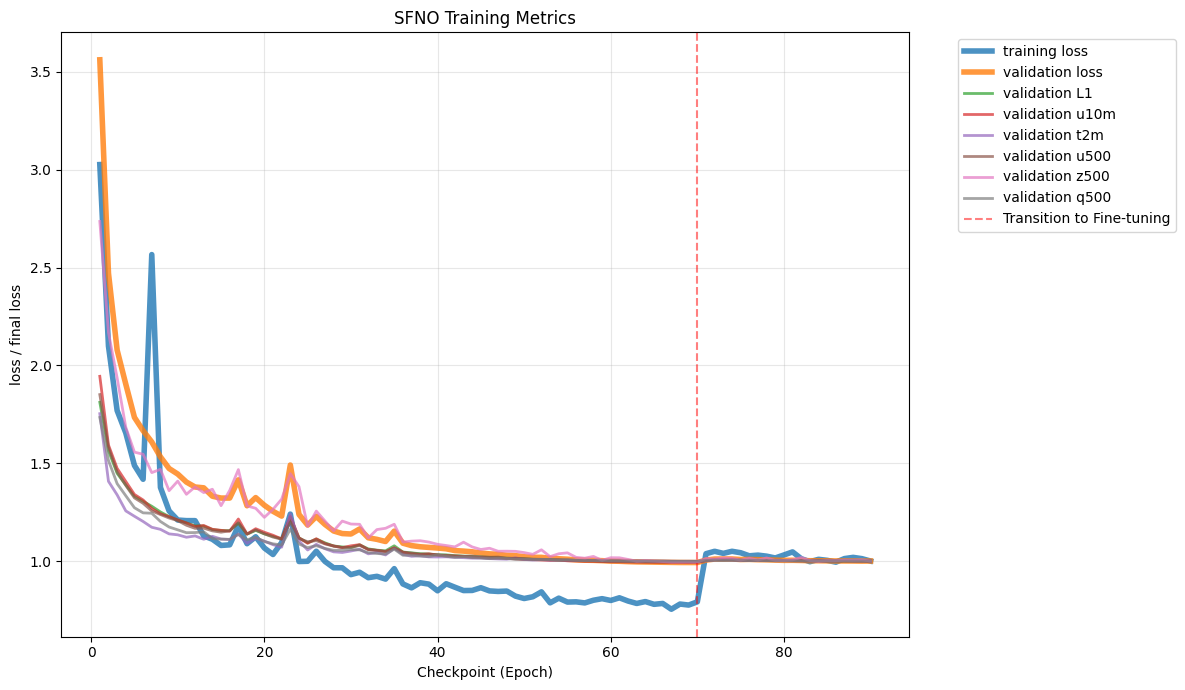

In [5]:
import re
import matplotlib.pyplot as plt
import numpy as np

def parse_metric(file_path, metric_name, epoch_offset=0):
    """Parses a specific metric from the log file."""
    epochs = []
    values = []
    
    with open(file_path, 'r') as f:
        content = f.read()
        pattern = re.compile(
            r"Epoch (\d+) summary:.*? " + re.escape(metric_name) + r":\s+([\d.e+-]+)", 
            re.DOTALL
        )
        
        matches = pattern.findall(content)
        for m in matches:
            epochs.append(int(m[0]) + epoch_offset)
            values.append(float(m[1]))
            
    return epochs, values

def plot_metrics(logs_with_offsets, metrics_to_plot, normalize=False):
    """
    logs_with_offsets: list of tuples (path, offset)
    metrics_to_plot: list of metric names (strings)
    normalize: If True, divides all values by the final value (Epoch 90).
    """
    plt.figure(figsize=(12, 7))
    
    for metric in metrics_to_plot:
        all_epochs = []
        all_values = []
        
        for path, offset in logs_with_offsets:
            e, v = parse_metric(path, metric, offset)
            all_epochs.extend(e)
            all_values.extend(v)
        
        if all_epochs:
            plot_values = np.array(all_values)
            label_suffix = ""
            
            if normalize:
                final_val = plot_values[-1]
                # Avoid division by zero
                if final_val != 0:
                    plot_values = plot_values / final_val
                
            if metric.lower() == 'training loss' or metric.lower() == 'validation loss':
                plt.plot(all_epochs, plot_values, label=f"{metric}{label_suffix}", 
                    #  marker='o', markersize=3,
                      linewidth=4, alpha=0.8)
            else:
                plt.plot(all_epochs, plot_values, label=f"{metric}{label_suffix}", 
                        #  marker='o', markersize=3,
                        linewidth=2, alpha=0.7)

    plt.axvline(x=70, color='red', linestyle='--', alpha=0.5, label='Transition to Fine-tuning')
    
    plt.xlabel('Checkpoint (Epoch)')
    plt.ylabel('loss / final loss' if normalize else 'Metric Value')
    
    # title_prefix = "Normalized " if normalize else ""
    plt.title(f'SFNO Training Metrics')
    #:\n{", ".join(metrics_to_plot)}')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

log1_path = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/out.log"
log2_path = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/out.log"

log_configs = [(log1_path, 0), (log2_path, 70)]

all_metrics = [
    'training loss', 'validation loss', 'validation L1', 
    'validation u10m', 'validation t2m', 'validation u500', 
    'validation z500', 'validation q500'
]

plot_metrics(log_configs, all_metrics, normalize=True)

# look at contents of wandb file


In [ ]:
/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/wandb/run-20250527_201829-zc1qwc98

# Look at contents of checkpoint files

In [ ]:
import torch
import os

dir='/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/training_checkpoints/' # step 1 of training (epochs 1-70)
dir2='/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/training_checkpoints/' # step 2 of training (epochs 71-90

# List of files to check
files_to_check = [dir + "best_ckpt_mp0.tar", 
                  dir + "ckpt_mp0.tar",
                  dir2 +  "best_ckpt_mp0.tar",
                    dir2 + "ckpt_mp0.tar"
                    ]
                
for filename in files_to_check:
    # Load the checkpoint
    # map_location='cpu' allows you to inspect this even without a GPU
    # weights_only=False allows loading the full dictionary structure
    checkpoint = torch.load(filename, map_location='cpu', weights_only=False)
    epoch = checkpoint.get('epoch', 'N/A')

    # print contents of checkpoint
    print(f"Contents of {filename}:")
    for key in checkpoint.keys():
        print(f"  {key}: type={type(checkpoint[key])}")

    print(checkpoint['optimizer_state_dict'].keys())
    
    # print(f'epoch: {str(epoch)}')
    print()

Contents of /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/training_checkpoints/best_ckpt_mp0.tar:
  iters: type=<class 'int'>
  epoch: type=<class 'int'>
  model_state: type=<class 'collections.OrderedDict'>
  optimizer_state_dict: type=<class 'dict'>
  params: type=<class 'makani.utils.YParams.YParams'>
  scheduler_state_dict: type=<class 'dict'>
dict_keys(['state', 'param_groups'])

Contents of /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/training_checkpoints/ckpt_mp0.tar:
  iters: type=<class 'int'>
  epoch: type=<class 'int'>
  model_state: type=<class 'collections.OrderedDict'>
  optimizer_state_dict: type=<class 'dict'>
  params: type=<class 'makani.utils.YParams.YParams'>
  scheduler_state_dict: type=<class 'dict'>
dict_keys(['state', 'param_groups'])

Contents of /projectnb/eb